# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [718]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [719]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [720]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [721]:
from torch.utils.data import DataLoader

def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # resize the images
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])

    # define dataset using ImageFolder
    dataset = datasets.ImageFolder(data_dir, transform)

    # create and return DataLoader
    return DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [722]:
# Define function hyperparameters
# REVIEWER:
# The batch size used is a bit too large. Try values like 16 to 32 for better results because
# If you choose a batch size too small then the gradients will become more unstable and would need to reduce the learning rate. So batch size and learning rate are linked.
# Also if one use a batch size too big then the gradients will become less noisy but it will take longer to converge.

batch_size = 128 # More than recommended
img_size = 32 # TODO: focus on 64x64 images later on

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

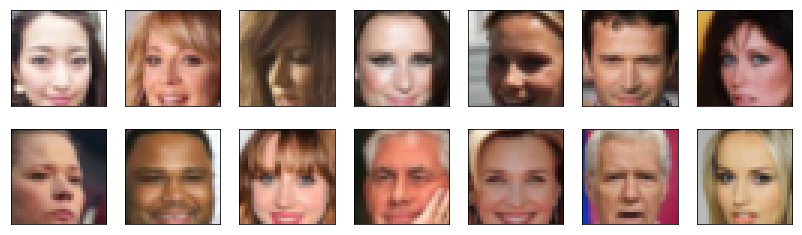

In [723]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(14, 4))
plot_size=14
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [724]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    rmin, rmax = feature_range
    return rmin + x * (rmax - rmin)


In [725]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8980)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [726]:
import torch.nn as nn
import torch.nn.functional as F

In [727]:
# REVIEWER
# Implement dropouts with low drop_prob in discriminator as mentioned at
# https://github.com/tensorflow/magenta/blob/master/magenta/reviews/GAN.md#disadvantages.
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        # complete init function
        # Convolutional layers, increasing in depth
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=conv_dim, 
                      kernel_size=3, stride=2, padding=1),
            nn.Dropout(0.01),             
            # first layer has *no* batchnorm
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=conv_dim, out_channels=conv_dim*2, 
                      kernel_size=3, stride=2, padding=1),
            nn.Dropout(0.01),             
            nn.BatchNorm2d(conv_dim*2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=conv_dim*2, out_channels=conv_dim*4, 
                      kernel_size=3, stride=2, padding=1),
            nn.Dropout(0.01),            
            nn.BatchNorm2d(conv_dim*4),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
        )
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*8*8, 1)


    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
#         print(x.shape)
        x = self.convs(x)
#         print(x.shape)
        # flatten
        x = x.view(x.size(0), -1)
#         print(x.shape)
        x = self.fc(x)
#         print(x.shape)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [728]:
# REVIEWER:
# Similar to implementing dropouts in D, as mentioned in section above, 
# use dropout after each deconv layer except the last.
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim

        # first, fully-connected layer, 2 fc is worse even with dropout
        self.fc = nn.Sequential(
            nn.Linear(z_size, conv_dim * 8 * 3 * 3),
            nn.Dropout(0.01))

        # complete init function
        # generator should have more complexity to generate better images
        self.deconvs = nn.Sequential(
            nn.ConvTranspose2d(in_channels=conv_dim*8, out_channels=conv_dim * 4, 
                               kernel_size=3, stride=2, padding=1),            
 
            nn.Dropout(0.01), 
            nn.BatchNorm2d(conv_dim*4),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=conv_dim*4, out_channels=conv_dim * 2, 
                               kernel_size=3, stride=2, padding=1),
            nn.Dropout(0.01), 
            nn.BatchNorm2d(conv_dim*2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=conv_dim*2, out_channels=conv_dim, 
                               kernel_size=3, stride=2, padding=1),
            nn.Dropout(0.01), 
            nn.BatchNorm2d(conv_dim),
            nn.LeakyReLU(),

            # last layer has *no* batchnorm
            nn.ConvTranspose2d(in_channels=conv_dim, out_channels=3, 
                               kernel_size=4, stride=2, padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
#         print(x.shape)
        # fully-connected + reshape 
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 3, 3)
#         print(x.shape)
        x = self.deconvs(x)
#         print(x.shape)
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [729]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname == 'Linear':
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Conv') != -1:
        m.weight.data.uniform_(0.0, 0.02)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [730]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [731]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64 # generator should have more complexity to generate better images + more conv layers
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Dropout(p=0.01)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): Dropout(p=0.01)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): Dropout(p=0.01)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.2)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=4608, bias=True)
    (1): Dropout(p=0.01)
  )
  (deconvs): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Dropout(p=0.01)
    (2):

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [732]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [733]:
def real_loss(D_out, smooth):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
#     if np.random.rand() < 0.05: # https://github.com/soumith/ganhacks
#         return fake_loss(D_out) 
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.rand(batch_size) * 0.5 + 0.7 # https://github.com/soumith/ganhacks
    else:
        labels = torch.ones(batch_size)
    # move x to GPU, if available
    if train_on_gpu:
        labels = labels.cuda()            
    
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    return criterion(D_out.squeeze(), labels)


def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.rand(batch_size) * 0.1 # https://github.com/soumith/ganhacks
    # move x to GPU, if available
    if train_on_gpu:
        labels = labels.cuda()            
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    return criterion(D_out.squeeze(), labels)

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [734]:
import torch.optim as optim

# Optimizers
# REVIEWER
# The beta1 is a bit too high. Values like 0.1 to 0.3 have shown to get best results.
# The current learning rate is okay but can be a bit high. 
# The DCGAN with this architectural structure remains stable with lr between 0.0002 and 0.001.
# params from original paper as start point
lr = 0.0002
beta1=0.2
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [735]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,2), nrows=1, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((img_size,img_size,3)))
    plt.show()

In [736]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=8
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            # Compute the discriminator losses on real images            
            # move x to GPU, if available
            if train_on_gpu:
                real_images = real_images.cuda()            
            d_real_loss = real_loss(D(real_images), smooth=True)

            # Compute the discriminator losses on fake images            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            # Generate them    
            fake_images = G(z)
            
            d_fake_loss = fake_loss(D(fake_images))

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Compute the discriminator losses on fake images 
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            # Generate them    
            fake_images = G(z)
            
            g_loss = real_loss(D(fake_images), smooth=False) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()

            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
        _ = view_samples(-1, samples)        

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

Epoch [    1/   10] | d_loss: 8.2742 | g_loss: 0.5368
Epoch [    1/   10] | d_loss: 1.2527 | g_loss: 0.7259
Epoch [    1/   10] | d_loss: 0.7371 | g_loss: 1.3968
Epoch [    1/   10] | d_loss: 0.6298 | g_loss: 1.8508
Epoch [    1/   10] | d_loss: 0.6429 | g_loss: 2.4515
Epoch [    1/   10] | d_loss: 1.5637 | g_loss: 1.1468
Epoch [    1/   10] | d_loss: 1.4082 | g_loss: 0.9305
Epoch [    1/   10] | d_loss: 1.3784 | g_loss: 0.7609
Epoch [    1/   10] | d_loss: 1.4169 | g_loss: 0.8392
Epoch [    1/   10] | d_loss: 1.3176 | g_loss: 0.7708
Epoch [    1/   10] | d_loss: 1.4069 | g_loss: 0.7405
Epoch [    1/   10] | d_loss: 1.3482 | g_loss: 0.7899
Epoch [    1/   10] | d_loss: 1.3686 | g_loss: 0.7631
Epoch [    1/   10] | d_loss: 1.3491 | g_loss: 0.7740
Epoch [    1/   10] | d_loss: 1.3427 | g_loss: 0.7431


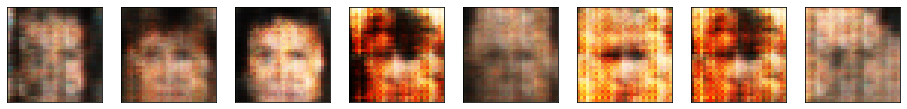

Epoch [    2/   10] | d_loss: 1.3602 | g_loss: 0.9111
Epoch [    2/   10] | d_loss: 1.3694 | g_loss: 0.8510
Epoch [    2/   10] | d_loss: 1.3698 | g_loss: 0.7839
Epoch [    2/   10] | d_loss: 1.4066 | g_loss: 0.7012
Epoch [    2/   10] | d_loss: 1.3272 | g_loss: 0.8568
Epoch [    2/   10] | d_loss: 1.3236 | g_loss: 0.7769
Epoch [    2/   10] | d_loss: 1.3822 | g_loss: 0.9144
Epoch [    2/   10] | d_loss: 1.2399 | g_loss: 0.8524
Epoch [    2/   10] | d_loss: 1.3575 | g_loss: 0.8412
Epoch [    2/   10] | d_loss: 1.4097 | g_loss: 0.7835
Epoch [    2/   10] | d_loss: 1.3746 | g_loss: 0.8523
Epoch [    2/   10] | d_loss: 1.3673 | g_loss: 0.8750
Epoch [    2/   10] | d_loss: 1.3939 | g_loss: 0.9094
Epoch [    2/   10] | d_loss: 1.4094 | g_loss: 1.0571
Epoch [    2/   10] | d_loss: 1.3949 | g_loss: 0.8648


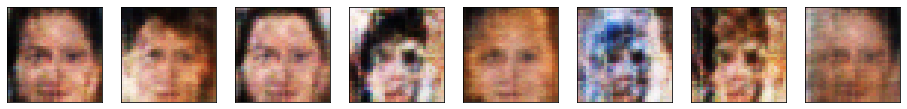

Epoch [    3/   10] | d_loss: 1.3293 | g_loss: 0.8340
Epoch [    3/   10] | d_loss: 1.3676 | g_loss: 0.8691
Epoch [    3/   10] | d_loss: 1.3485 | g_loss: 0.8800
Epoch [    3/   10] | d_loss: 1.3304 | g_loss: 0.7631
Epoch [    3/   10] | d_loss: 1.3160 | g_loss: 0.7544
Epoch [    3/   10] | d_loss: 1.4282 | g_loss: 0.6738
Epoch [    3/   10] | d_loss: 1.3879 | g_loss: 1.0996
Epoch [    3/   10] | d_loss: 1.3420 | g_loss: 0.7511
Epoch [    3/   10] | d_loss: 1.3498 | g_loss: 0.7843
Epoch [    3/   10] | d_loss: 1.3395 | g_loss: 0.8493
Epoch [    3/   10] | d_loss: 1.3095 | g_loss: 0.8149
Epoch [    3/   10] | d_loss: 1.3323 | g_loss: 0.9409
Epoch [    3/   10] | d_loss: 1.3346 | g_loss: 0.8530
Epoch [    3/   10] | d_loss: 1.3555 | g_loss: 0.7820
Epoch [    3/   10] | d_loss: 1.3032 | g_loss: 0.7843


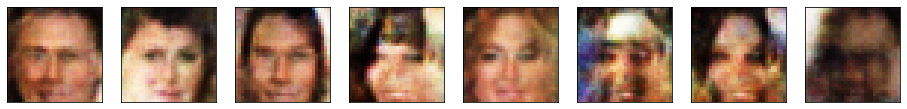

Epoch [    4/   10] | d_loss: 1.3146 | g_loss: 0.8559
Epoch [    4/   10] | d_loss: 1.2702 | g_loss: 0.9509
Epoch [    4/   10] | d_loss: 1.3839 | g_loss: 0.8220
Epoch [    4/   10] | d_loss: 1.3189 | g_loss: 0.9145
Epoch [    4/   10] | d_loss: 1.3207 | g_loss: 0.9078
Epoch [    4/   10] | d_loss: 1.3359 | g_loss: 0.7345
Epoch [    4/   10] | d_loss: 1.3350 | g_loss: 0.7470
Epoch [    4/   10] | d_loss: 1.3436 | g_loss: 0.8759
Epoch [    4/   10] | d_loss: 1.3723 | g_loss: 0.5871
Epoch [    4/   10] | d_loss: 1.3392 | g_loss: 0.8122
Epoch [    4/   10] | d_loss: 1.3352 | g_loss: 0.9580
Epoch [    4/   10] | d_loss: 1.3365 | g_loss: 0.7236
Epoch [    4/   10] | d_loss: 1.3648 | g_loss: 1.1031
Epoch [    4/   10] | d_loss: 1.3318 | g_loss: 0.9838
Epoch [    4/   10] | d_loss: 1.2730 | g_loss: 0.8467


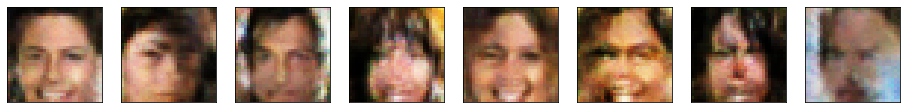

Epoch [    5/   10] | d_loss: 1.3517 | g_loss: 0.9228
Epoch [    5/   10] | d_loss: 1.3698 | g_loss: 0.7851
Epoch [    5/   10] | d_loss: 1.3256 | g_loss: 0.8323
Epoch [    5/   10] | d_loss: 1.3805 | g_loss: 0.9337
Epoch [    5/   10] | d_loss: 1.3311 | g_loss: 0.8359
Epoch [    5/   10] | d_loss: 1.2693 | g_loss: 0.9677
Epoch [    5/   10] | d_loss: 1.2942 | g_loss: 0.8933
Epoch [    5/   10] | d_loss: 1.3317 | g_loss: 0.8347
Epoch [    5/   10] | d_loss: 1.2973 | g_loss: 0.7486
Epoch [    5/   10] | d_loss: 1.3284 | g_loss: 0.7308
Epoch [    5/   10] | d_loss: 1.3409 | g_loss: 0.9256
Epoch [    5/   10] | d_loss: 1.3281 | g_loss: 1.0798
Epoch [    5/   10] | d_loss: 1.3228 | g_loss: 0.8298
Epoch [    5/   10] | d_loss: 1.3658 | g_loss: 0.9449
Epoch [    5/   10] | d_loss: 1.3179 | g_loss: 0.8763


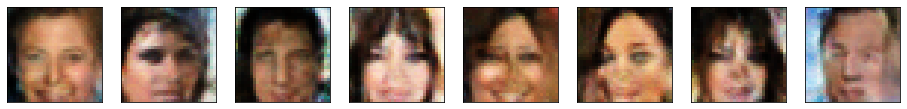

Epoch [    6/   10] | d_loss: 1.3454 | g_loss: 0.5997
Epoch [    6/   10] | d_loss: 1.3562 | g_loss: 0.8157
Epoch [    6/   10] | d_loss: 1.2875 | g_loss: 0.8243
Epoch [    6/   10] | d_loss: 1.3210 | g_loss: 0.8967
Epoch [    6/   10] | d_loss: 1.3208 | g_loss: 0.8404
Epoch [    6/   10] | d_loss: 1.3269 | g_loss: 0.7582
Epoch [    6/   10] | d_loss: 1.3031 | g_loss: 0.8195
Epoch [    6/   10] | d_loss: 1.3408 | g_loss: 0.8805
Epoch [    6/   10] | d_loss: 1.3256 | g_loss: 0.7417
Epoch [    6/   10] | d_loss: 1.3234 | g_loss: 0.8839
Epoch [    6/   10] | d_loss: 1.2889 | g_loss: 0.7970
Epoch [    6/   10] | d_loss: 1.3168 | g_loss: 0.8998
Epoch [    6/   10] | d_loss: 1.2706 | g_loss: 0.8323
Epoch [    6/   10] | d_loss: 1.3460 | g_loss: 0.7968
Epoch [    6/   10] | d_loss: 1.3088 | g_loss: 1.0077


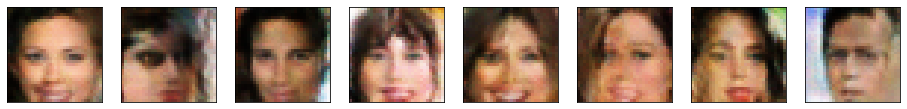

Epoch [    7/   10] | d_loss: 1.3493 | g_loss: 0.6506
Epoch [    7/   10] | d_loss: 1.2680 | g_loss: 0.8408
Epoch [    7/   10] | d_loss: 1.3010 | g_loss: 0.7567
Epoch [    7/   10] | d_loss: 1.2735 | g_loss: 0.7555
Epoch [    7/   10] | d_loss: 1.3173 | g_loss: 0.8985
Epoch [    7/   10] | d_loss: 1.3398 | g_loss: 0.7721
Epoch [    7/   10] | d_loss: 1.3334 | g_loss: 0.9490
Epoch [    7/   10] | d_loss: 1.3199 | g_loss: 1.0066
Epoch [    7/   10] | d_loss: 1.2911 | g_loss: 0.7873
Epoch [    7/   10] | d_loss: 1.2997 | g_loss: 0.8665
Epoch [    7/   10] | d_loss: 1.3698 | g_loss: 0.7273
Epoch [    7/   10] | d_loss: 1.3275 | g_loss: 0.8089
Epoch [    7/   10] | d_loss: 1.3133 | g_loss: 0.8189
Epoch [    7/   10] | d_loss: 1.2914 | g_loss: 0.8113
Epoch [    7/   10] | d_loss: 1.3495 | g_loss: 0.8408


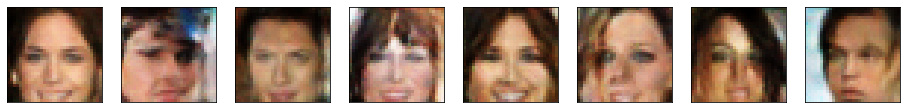

Epoch [    8/   10] | d_loss: 1.3243 | g_loss: 0.9304
Epoch [    8/   10] | d_loss: 1.2928 | g_loss: 1.0422
Epoch [    8/   10] | d_loss: 1.2645 | g_loss: 0.8664
Epoch [    8/   10] | d_loss: 1.3089 | g_loss: 0.8789
Epoch [    8/   10] | d_loss: 1.2723 | g_loss: 0.9323
Epoch [    8/   10] | d_loss: 1.2794 | g_loss: 0.9340
Epoch [    8/   10] | d_loss: 1.2666 | g_loss: 0.8350
Epoch [    8/   10] | d_loss: 1.2876 | g_loss: 0.9478
Epoch [    8/   10] | d_loss: 1.3088 | g_loss: 0.9633
Epoch [    8/   10] | d_loss: 1.3213 | g_loss: 0.8097
Epoch [    8/   10] | d_loss: 1.2450 | g_loss: 1.0511
Epoch [    8/   10] | d_loss: 1.4430 | g_loss: 1.1882
Epoch [    8/   10] | d_loss: 1.2980 | g_loss: 0.6845
Epoch [    8/   10] | d_loss: 1.3136 | g_loss: 0.9532
Epoch [    8/   10] | d_loss: 1.2696 | g_loss: 0.9196


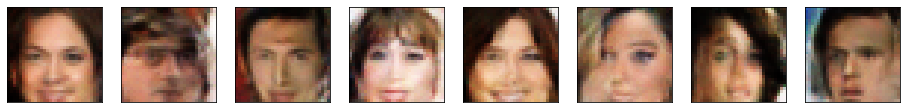

Epoch [    9/   10] | d_loss: 1.2844 | g_loss: 0.8682
Epoch [    9/   10] | d_loss: 1.2636 | g_loss: 0.8246
Epoch [    9/   10] | d_loss: 1.2974 | g_loss: 0.7091
Epoch [    9/   10] | d_loss: 1.3080 | g_loss: 0.9622
Epoch [    9/   10] | d_loss: 1.2392 | g_loss: 0.7661
Epoch [    9/   10] | d_loss: 1.3106 | g_loss: 0.8903
Epoch [    9/   10] | d_loss: 1.3258 | g_loss: 1.0434
Epoch [    9/   10] | d_loss: 1.2922 | g_loss: 1.0096
Epoch [    9/   10] | d_loss: 1.2748 | g_loss: 0.9507
Epoch [    9/   10] | d_loss: 1.2603 | g_loss: 0.9537
Epoch [    9/   10] | d_loss: 1.2773 | g_loss: 0.8497
Epoch [    9/   10] | d_loss: 1.2584 | g_loss: 0.9665
Epoch [    9/   10] | d_loss: 1.2639 | g_loss: 0.8858
Epoch [    9/   10] | d_loss: 1.3293 | g_loss: 0.9526
Epoch [    9/   10] | d_loss: 1.2439 | g_loss: 0.9822


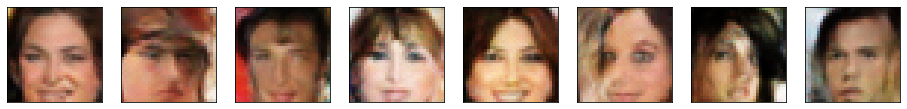

Epoch [   10/   10] | d_loss: 1.2849 | g_loss: 0.7998
Epoch [   10/   10] | d_loss: 1.1802 | g_loss: 0.9997
Epoch [   10/   10] | d_loss: 1.2640 | g_loss: 0.8359
Epoch [   10/   10] | d_loss: 1.2480 | g_loss: 0.8537
Epoch [   10/   10] | d_loss: 1.2708 | g_loss: 1.0124
Epoch [   10/   10] | d_loss: 1.3278 | g_loss: 1.2313
Epoch [   10/   10] | d_loss: 1.2423 | g_loss: 0.9063
Epoch [   10/   10] | d_loss: 1.3714 | g_loss: 1.2305
Epoch [   10/   10] | d_loss: 1.2038 | g_loss: 0.9958
Epoch [   10/   10] | d_loss: 1.2935 | g_loss: 0.9136
Epoch [   10/   10] | d_loss: 1.2297 | g_loss: 0.9541
Epoch [   10/   10] | d_loss: 1.1982 | g_loss: 0.8033
Epoch [   10/   10] | d_loss: 1.2831 | g_loss: 0.9154
Epoch [   10/   10] | d_loss: 1.2125 | g_loss: 1.0317
Epoch [   10/   10] | d_loss: 1.2349 | g_loss: 0.8269


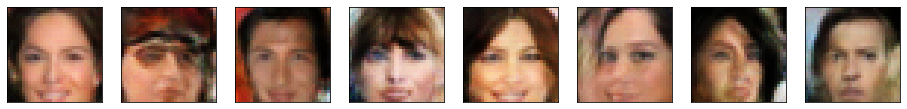

In [737]:
# set number of epochs 
n_epochs = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

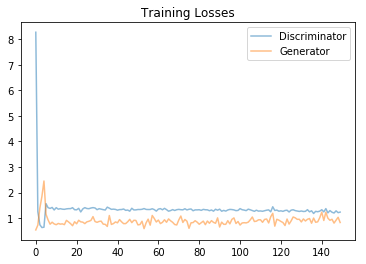

In [738]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [739]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

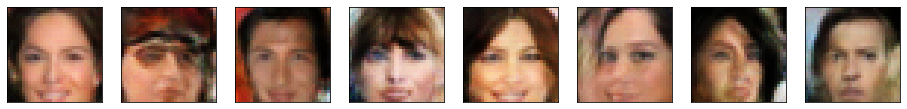

In [740]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

**How model was built**:
First of all I took the model from DCGAN project and started with it as a baseline. It results were not good at all. In this model Generator and Discriminator complexity were almost the same, however some posts on Students Hub suggested that Generator should be more complex than Discriminator model. So I added additional convolutional transpose layer to it. Results became better. After this I've read GanHacks GitHub repository - https://github.com/soumith/ganhacks and modified loss functions, switched to LeakyRelu to avoid sparsity in Gans, added Dropout to the Discriminator and switched to odd kernel sizes. During the experiments I've logged visual results on the end of each epoch. This allowed to eliminate bad decisions fast. It was interesting that increasing batch size to 512 or 1024 lead to worse results. Gans are sensitive to optimization algorithms and parameters, so I started with parameters described in original paper. Although the values of d_loss and g_loss are not that close to 0 images quality increasing steadily, and these values are just a consequence of explicitly adding noise to loss functions. 

**How it might be improved**
First of all the training data itself is low quality, blurry etc. Increasing the training dataset quality may improve the resuts. Increasing size of pictures may help models to decect more features. Also preprocessing may be more gentle to avoid blur in training dataset. Increasing the dimensionality of z vector and number of filters may help generating images of better quality.  Number of epochs chosen here is 20, increasing this number might increase the quality of produced images. In DCGAN example the suggested kernel size was 4, however some of reviews suggested to avoid even kernels. Probably tweaking kernel size/stride/padding may increase the quality. The dataset is biased, "celebrety" faces are mostly white, which is reflected in generated results keeping the same distribution of color. Making Generator more complicated and powerful might increase the quality, however increasing fc layer complexity didn't help.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.